In [47]:
import geopandas as gp
import networkx as nx
from shapely.geometry import box
import pandas as pd
from shapely.geometry import Point
from lib_orca import orcastr
import warnings
warnings.filterwarnings('ignore')

In [48]:
country = gp.read_file('maps/estonia2020/')

In [49]:
country.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,3870673,5114,secondary,Kohtla-Järve — Kukruse — Tammiku,93,B,0,0,F,F,"LINESTRING (27.27461 59.41971, 27.27519 59.41644)"
1,3870677,5122,residential,Olevi,None,B,0,0,F,F,"LINESTRING (27.28343 59.40574, 27.28208 59.405..."
2,3870681,5122,residential,Pärna,None,B,0,0,F,F,"LINESTRING (27.29468 59.40214, 27.29445 59.402..."
3,3870683,5122,residential,None,None,B,0,0,F,F,"LINESTRING (27.29432 59.39381, 27.29412 59.394..."
4,3931892,5115,tertiary,Tööstuse,None,B,0,0,F,F,"LINESTRING (26.09132 59.16187, 26.09163 59.162..."


<Axes: >

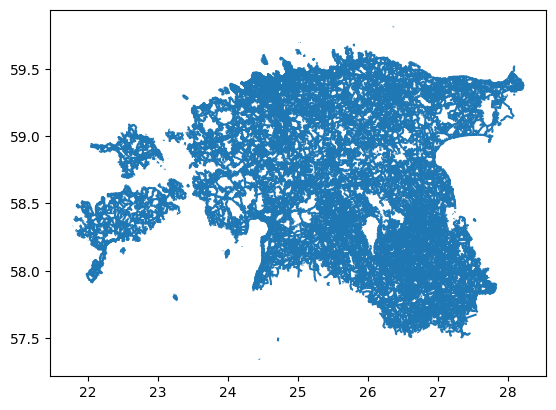

In [50]:
country.plot()

# Define the bonding box

In [51]:
bounding_box = (24.5, 59.3, 25, 59.5)

In [52]:
# Create a GeoDataFrame from the bounding box
bbox_geom = box(*bounding_box)
bbox_gdf = gp.GeoDataFrame({"geometry": [bbox_geom]}, crs="EPSG:4326")


In [53]:
# Filter the shapefile within the bounding box
study_area = country[country.geometry.intersects(bbox_geom)]

<Axes: >

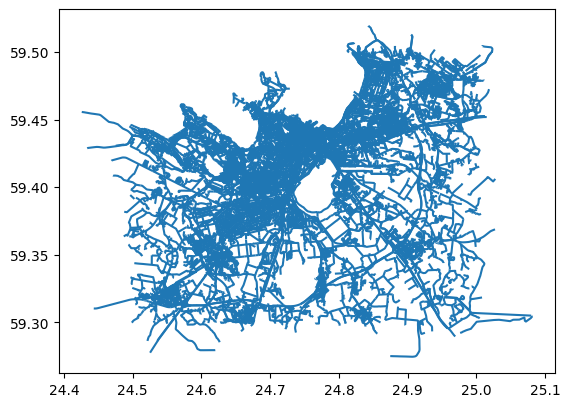

In [54]:
study_area.plot()

# Making the Graph

In [55]:
# Create a graph
G = nx.Graph()

# Iterate through the GeoDataFrame rows
for idx, row in study_area.iterrows():
    if row.geometry.geom_type == "LineString":
        # Extract coordinates from the LineString
        coords = list(row.geometry.coords)
        # Add edges for each consecutive pair of points
        for start, end in zip(coords[:-1], coords[1:]):
            G.add_edge(start, end, **row.to_dict())  # Add attributes as edge data

# Optionally, check the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 147151 nodes and 166155 edges.


# Graphlet decomposition

In [56]:
uv = []
# This function will count graphlets
def graphlet_counts(task, size, graph):
    graph = nx.convert_node_labels_to_integers(graph)
    s = "{} {}\n".format(len(graph), len(graph.edges))
    for u, v in graph.edges:
        if u == v: continue
        if (u,v) not in uv: 
            uv.append((u,v))
            s += "{} {}\n".format(u, v)
    out = orcastr.motif_counts_str(task, size, s)
    out = [[int(c) for c in s.split(" ")] for s in out.split("\n") if s]
    return out

In [57]:
# mapping between number of nodes and number of graphlets
size_table = { 2:1, 3:4, 4:15, 5:73}
size = 4
graphlets = graphlet_counts("node", size, G)

In [58]:
data = []
for n,g in zip(G.nodes,graphlets):
    data.append([n,*g])

## Saving graphlets for each node in CSV format.

In [59]:
df = pd.DataFrame(data,columns=['coordinates']+[f"graphlet_{i}" for i in range(size_table[size])])
df.to_csv("output/graphlet.csv", index=False)
df.head(3)

,coordinates,graphlet_0,graphlet_1,graphlet_2,graphlet_3,graphlet_4,graphlet_5,graphlet_6,graphlet_7,graphlet_8,graphlet_9,graphlet_10,graphlet_11,graphlet_12,graphlet_13,graphlet_14
0,"(24.664454, 59.3972698)",3,7,3,0,15,14,5,1,0,0,0,0,0,0,0
1,"(24.6645921, 59.397401)",4,7,6,0,16,21,4,4,0,0,0,0,0,0,0
2,"(24.6648219, 59.3976166)",4,11,6,0,19,33,9,4,0,1,0,0,0,0,0


# Make .SHP file to show graphlets on the map

In [60]:
df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))
gdf = gp.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
del gdf['coordinates']
gdf.head()

,graphlet_0,graphlet_1,graphlet_2,graphlet_3,graphlet_4,graphlet_5,graphlet_6,graphlet_7,graphlet_8,graphlet_9,graphlet_10,graphlet_11,graphlet_12,graphlet_13,graphlet_14,geometry
0,3,7,3,0,15,14,5,1,0,0,0,0,0,0,0,POINT (24.66445 59.39727)
1,4,7,6,0,16,21,4,4,0,0,0,0,0,0,0,POINT (24.66459 59.3974)
2,4,11,6,0,19,33,9,4,0,1,0,0,0,0,0,POINT (24.66482 59.39762)
3,3,7,3,0,17,14,5,1,0,0,0,0,0,0,0,POINT (24.66527 59.39805)
4,3,6,3,0,11,12,3,1,0,0,0,0,0,0,0,POINT (24.66529 59.39807)


<Axes: >

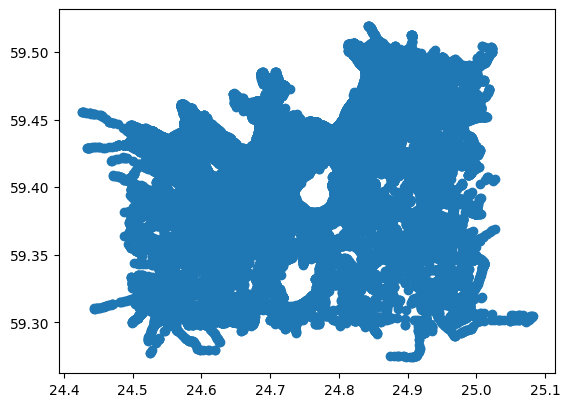

In [61]:
gdf.plot()

In [62]:
gdf.to_file("output/graphlet.shp", driver="ESRI Shapefile")